# Unsupervised Anomaly Detection using Vector Embeddings from <U>doc2vec model</U>
This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. in this working example, we will build a doc2vec model using sample mixed benign/malicious logs and use that to calculate vector embeddings for the logs we wish to analyze for anomalies.

In [11]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install gensim
#! pip install nltk
#import nltk
#nltk.download('punkt_tab')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

In [2]:
# Build a vector embedding model with doc2vec using the benign sample logs
#df = pd.read_csv('proxy_logs_good.csv') # Good logs only did not produce very good results.
#df = pd.read_csv('proxy_logs_mixed.csv') # Using the mixed logs produced the best results.
df = pd.read_csv('proxy_logs_mixed-2.csv') # Let's try a different set of mixed logs
# It turns out that building the embedding model with mixed logs seems to result in better accuracy, so
# I generated a new set of mixed logs.  It's not good practice to train a model on the the same data
# you want to use for it's predictions...of course that scores well on accuracy.
documents = df['Log Entry'].values

# Generate the tagged documents
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(documents)]

# vector_size: size of the document vectors
# window: context window size (how many words before and after to look)
# min_count: minimum word frequency
# workers: number of CPU cores to use
# dm: 1 for Distributed Memory (DM), 0 for Distributed Bag of Words (DBOW)
embedder_model = Doc2Vec(vector_size=32, window=5, min_count=2, workers=4, dm=1)

# Build vocabulary
embedder_model.build_vocab(tagged_data)

# Train the model
embedder_model.train(tagged_data, total_examples=embedder_model.corpus_count, epochs=embedder_model.epochs)

# Save the model
embedder_model.save("doc2vec-embedding-model_benign-proxy-logs-v1.model")


In [3]:
# Do a test inference to see if the vector embedding looks like something we'd expect...so far, so good
new_doc = word_tokenize('GET http://www.example.com/ HTTP/1.1"" 200 140321 ""http://www.example.com/"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15')
sample_vector = embedder_model.infer_vector(new_doc)
sample_vector


array([-0.00569879, -0.08602417,  0.0095491 , -0.01191117,  0.00850165,
       -0.0305405 ,  0.00406921,  0.00852855, -0.00543939, -0.0116599 ,
       -0.00091891, -0.03656041,  0.00903704,  0.02589294, -0.01380745,
       -0.03287099, -0.01233122,  0.02984854, -0.00621859,  0.00030328,
        0.03108601,  0.02393611,  0.04139601,  0.01303543,  0.03879041,
       -0.01289934, -0.02389878, -0.02943346,  0.03338426, -0.02278683,
       -0.02877934,  0.02887498], dtype=float32)

In [4]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df['return_code'] = df['Log Entry'].str.split().str[3]

df.sample(3)

,ID,Log Entry,return_code
273,274,GET http://update.software.com/version.xml HTT...,200
1,2,"GET http://intranet.company.com/home HTTP/1.1""...",200
876,877,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200


In [5]:
# Let's confirm that we have 950 benign (rc = 200) and 50 malicious (rc != 200)
df['return_code'].value_counts()

return_code
200    950
403     18
500     11
404     11
400     10
Name: count, dtype: int64

In [6]:
# We'll use the doc2vec model that we trained above to calculate vector embeddings for these logs

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text: embedder_model.infer_vector(word_tokenize(text.lower())))

df.sample(3)

,ID,Log Entry,return_code,embedding
366,367,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[0.0090574045, 0.0031981205, 0.046121597, 0.00..."
514,515,"GET http://www.example.com/ HTTP/1.1"" 200 8012...",200,"[0.005256415, -0.0884729, 0.04216643, 0.006695..."
754,755,"GET http://cloudstorage.com/files HTTP/1.1"" 20...",200,"[-0.021079807, -0.06619769, 0.008000394, -0.00..."


In [7]:
# Define a model object with the Isolation Forest algorithm
model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding'].values)

# Fit the data to the model
model.fit(X)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [8]:
# Add a column to the DF for scores from the model's decision_function
df['raw_score'] = model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(X)


In [9]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
683,684,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[0.0036552171, -0.10537833, 0.014940785, 0.026...",0.122426,1
200,201,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200,"[-0.009385485, -0.07269167, 0.0054921545, -0.0...",0.136838,1
756,757,"GET http://www.example.com/ HTTP/1.1"" 200 8025...",200,"[-0.01080366, -0.14782904, 0.05143532, 0.02413...",0.108740,1


In [10]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
973,974,GET http://www.example.com/search?q=<script>al...,400,"[0.12886596, -0.26144055, 0.09626047, -0.11759...",-0.165073,-1
966,967,GET http://www.example.com/login.php?user=admi...,400,"[0.1077262, -0.13660127, 0.06255466, -0.037763...",-0.086883,-1
972,973,GET http://www.example.com/search?q=<script>al...,404,"[0.06652092, -0.2398456, 0.15489013, -0.048868...",-0.177757,-1


In [11]:
# The outliers have anomaly_score = -1 
# This output is much better than the 711/289 split we got from prior clustering exercises.
# NOTE:  Setting max_samples very high helps...the output below is very close to the known 950/50

# We could perhaps dig into the data to validate, then adjust contamination parameter to get better 
# on-going accuracy from this unsupervised algorithm. It would be worth trying with real data.
df['anomaly_score'].value_counts()

anomaly_score
 1    946
-1     54
Name: count, dtype: int64

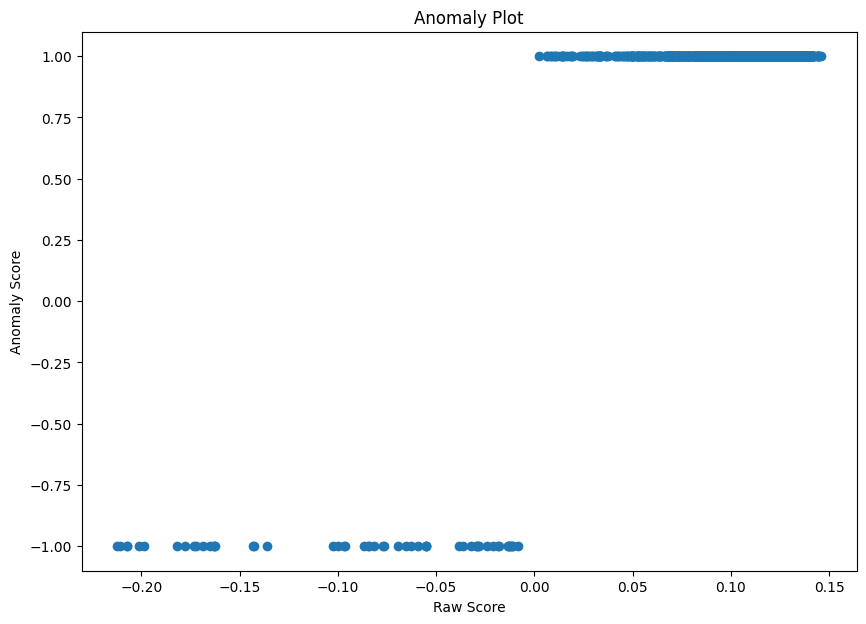

In [12]:
# If we just do a scatter plot of the anomaly_score results, it's very clear...but doesn't really tell us much.
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.raw_score, df.anomaly_score)
plt.title('Anomaly Plot')
plt.xlabel('Raw Score')
plt.ylabel('Anomaly Score')
plt.show()

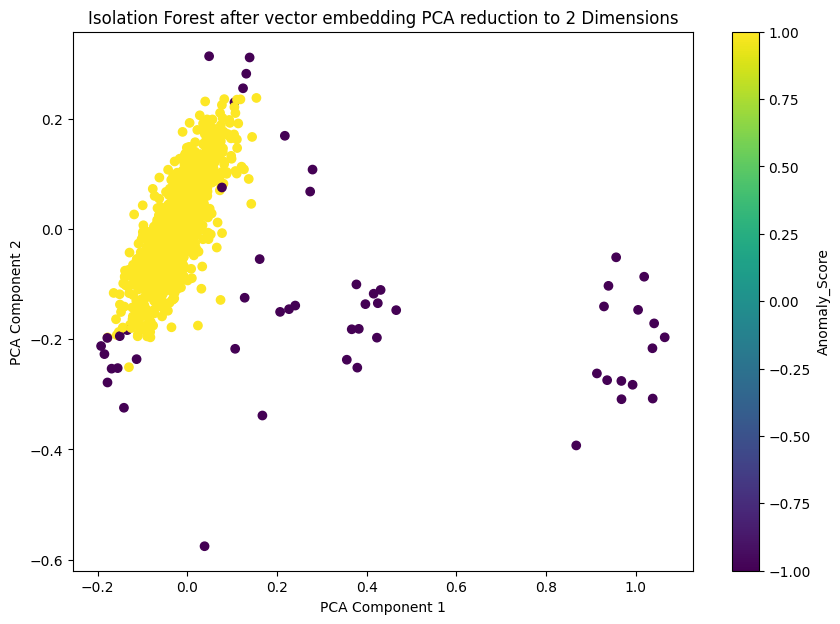

In [13]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings = df['embedding'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['anomaly_score'], cmap='viridis', marker='o')
plt.title('Isolation Forest after vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

# Judging from the plot, this appears to have done a decent job with the anomaly detection

In [14]:
# Let's examine whether the flagged anomalies include the 50 known malicious log entries
print("GOOD: Count of entries flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))
print("FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("GOOD: Count of entries not flagged anomaly and return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))

GOOD: Count of entries flagged anomaly and return_code not 200: 38
FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: 16
FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: 12
GOOD: Count of entries not flagged anomaly and return_code is 200: 934


In [16]:
# This approached returned a little too many "false negatives"...since the Isolation Forest model is 
# exactly the same as our previous experiments, the accuracy of the vector embeddings have to be the
# issue...our doc2vec embedding model is not as accurate as we'd like.
pd.set_option('max_colwidth', None) # show full width of cols
df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score', 'Log Entry']]


,return_code,anomaly_score,Log Entry
951,403,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 403 183373 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
957,403,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 403 66239 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
959,404,1,"GET http://www.example.com/admin HTTP/1.1"" 404 997522 ""http://www.example.com/admin"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
960,403,1,"GET http://www.example.com/admin HTTP/1.1"" 403 98619 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
961,404,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 404 395488 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
962,400,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 400 629681 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
963,404,1,"GET http://www.example.com/admin HTTP/1.1"" 404 603181 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
967,404,1,"GET http://www.example.com/../../etc/passwd HTTP/1.1"" 404 24240 ""http://www.example.com/../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
976,500,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 500 16434 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
995,400,1,"GET http://www.example.com/admin HTTP/1.1"" 400 809282 ""http://www.example.com/admin"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"


In [17]:
# Let's examine the "false positives"...rows flagged as anomaly but have return_code 200
pd.set_option('max_colwidth', None) # show full width of showing cols
df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score', 'Log Entry']]


,return_code,anomaly_score,Log Entry
145,200,-1,"GET http://www.example.com/ HTTP/1.1"" 200 607283 ""http://www.example.com/"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
183,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 990601 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
264,200,-1,"GET http://cloudstorage.com/login HTTP/1.1"" 200 388319 ""http://cloudstorage.com/login"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
368,200,-1,"GET http://www.example.com/style.css HTTP/1.1"" 200 440441 ""http://www.example.com/style.css"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
375,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 687332 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
379,200,-1,"GET http://cloudstorage.com/files HTTP/1.1"" 200 793188 ""http://cloudstorage.com/files"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
406,200,-1,"GET http://www.example.com/script.js HTTP/1.1"" 200 363911 ""http://www.example.com/script.js"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
534,200,-1,"GET http://www.example.com/style.css HTTP/1.1"" 200 320652 ""http://www.example.com/style.css"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
567,200,-1,"GET http://intranet.company.com/home HTTP/1.1"" 200 977310 ""http://intranet.company.com/home"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
586,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 708809 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"


We know from our previous similar exercise that Isolation Forest did a very good job of finding anomalies in this sample data if we give it accurate vector embeddings as the input.  Unlike using a basic vector embedding LLM, our home-grown doc2vec model did an OK job in producing vector embeddings that capture the "semantic understanding" of what a malicious vs benign log appears to be. We can examine if adjusting vector dimensions, using a larger dataset, and tuning some of the model parameters has a positive impact on it's accuracy. However, those exercises are probably not that worthwhile with sample data. Both of the models we've built are unsupervised models, but we do have a hidden label in the data (the return code).  We don't know for certain if either of the models is noticing that and making it's predictions off of that attribute.  It's likely to some extent.  Note: If you want a production process to be data-driven, make sure you feed it good data.

It's also worth noting that running this notebook multiple times with produce slightly different results.  ML is, after all, based on inferential statistics...but we'd still like to see results that are a little more deterministic and reproducible. Data-driven processes are truly only as good as the data you feed them, and the inconsistencies we see are most likely products of the sample data we used in this example. 